<a href="https://colab.research.google.com/github/nkchaithu/ML-programs/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('processed.cleveland.data', header=None)
# this next line deals with possible numeric errors
df = df.apply(pd.to_numeric, errors='coerce').dropna()
X = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
y = df[13].values

In [ ]:
from tensorflow.keras import backend as K
def sampling(z_params):
 z_mean, z_log_var = z_params
 batch = K.shape(z_mean)[0]
 dims = K.int_shape(z_mean)[1]
 epsilon = K.random_normal(shape=(batch, dims))
 return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(X)
original_dim = x_train.shape[1]

In [ ]:
input_shape = (original_dim, )
intermediate_dim = 13
batch_size = 18 # comes from ceil(sqrt(x_train.shape[0]))
latent_dim = 2 # useful for visualization
epochs = 500

In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Model
inputs = Input(shape=input_shape)
bn = BatchNormalization()(inputs)
dp = Dropout(0.2)(bn)
x = Dense(intermediate_dim, activation='sigmoid')(dp)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z_params = [z_mean, z_log_var]
z = Lambda(sampling, output_shape=(latent_dim,))(z_params)
encoder = Model(inputs, [z_mean, z_log_var, z])

In [ ]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
r_outputs = Dense(original_dim)(x) # reconstruction outputs
decoder = Model(latent_inputs, r_outputs)


In [ ]:
outputs = decoder(encoder(inputs)[2]) # it is index 2 since we want z
vae = Model(inputs, outputs)

In [ ]:
from tensorflow.keras.losses import mse
r_loss = mse(inputs, outputs)

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
r_loss = binary_crossentropy(inputs, outputs)


In [ ]:
r_loss = original_dim * r_loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = 0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(r_loss + kl_loss)
vae.add_loss(vae_loss)


In [ ]:
vae.compile(optimizer='adam')
hist = vae.fit(x_train, epochs=epochs,batch_size=batch_size, validation_data=(x_train, None))


Epoch 1/500
17/17 [==============================] - 1s 14ms/step - loss: 14.9265 - val_loss: 12.7179
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 12.5182 - val_loss: 8.3726
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 12.5808 - val_loss: 10.0241
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 6.7902 - val_loss: 5.2807
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 4.7388 - val_loss: 3.4282
Epoch 6/500
17/17 [==============================] - 0s 4ms/step - loss: 6.5052 - val_loss: 4.2232
Epoch 7/500
17/17 [==============================] - 0s 4ms/step - loss: 1.1285 - val_loss: 1.5541
Epoch 8/500
17/17 [==============================] - 0s 4ms/step - loss: 1.5724 - val_loss: 2.6307
Epoch 9/500
17/17 [==============================] - 0s 4ms/step - loss: 0.1924 - val_loss: 1.3425
Epoch 10/500
17/17 [==============================] - 0s 3ms/step - loss: 1.6151 - val_loss: -0.4321
Ep

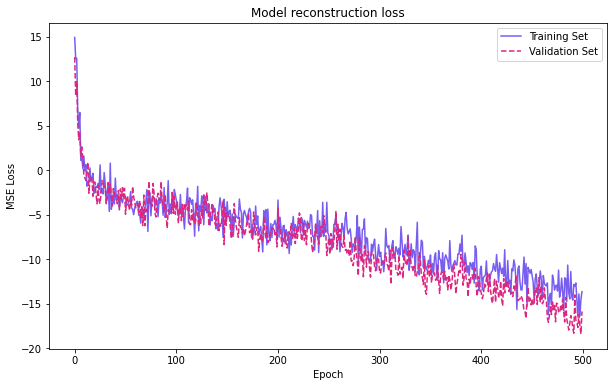

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], '--', color='#dc267f')
plt.title('Model reconstruction loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

In [ ]:
encdd = encoder.predict(x_train)
x_hat = decoder.predict(encdd[0])

10/10 [==============================] - 0s 2ms/step


In [ ]:
def generate_samples(N = 10, latent_dim = 2):
 noise = np.random.uniform(-2.0, 2.0, (N,latent_dim))
 gen = decoder.predict(noise)
 return gen


In [ ]:
gen = generate_samples(10, latent_dim)
print(np.around(scaler.inverse_transform(gen), decimals=1))

1/1 [==============================] - 0s 17ms/step
[[ 57.2   0.9   3.5 129.2 212.6  -0.    1.3 145.1   0.2   1.1   1.3   0.6
    5.4]
 [ 55.6   0.7   2.9 128.4 245.5   0.    1.  144.4   0.2   1.2   1.3   0.7
    3.8]
 [ 54.8   0.8   3.2 127.3 235.1   0.1   1.2 147.    0.3   0.9   1.4   0.4
    4.8]
 [ 53.    0.9   3.  117.6 205.5   0.    1.3 144.    0.3   0.8   1.2  -0.3
    5. ]
 [ 58.1   0.8   3.7 133.7 215.5   0.    1.3 145.6   0.1   1.3   1.4   0.8
    5.5]
 [ 55.    0.7   2.9 127.3 246.6   0.    0.9 148.1   0.1   1.1   1.3   0.8
    3.8]
 [ 52.4   0.8   2.9 121.1 233.3   0.    1.1 152.7   0.2   0.6   1.3   0.
    4.3]
 [ 51.4   0.6   2.7 124.8 254.8  -0.    0.7 161.4  -0.1   0.7   1.5   0.7
    3.7]
 [ 51.8   0.6   2.7 123.1 253.8  -0.    0.6 161.3  -0.2   0.7   1.4   0.9
    3.5]
 [ 57.9   0.7   3.4 136.9 245.8   0.1   1.2 144.4   0.3   1.2   1.5   0.8
    4.4]]


In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.models import Model
inpt_dim = 28*28
ltnt_dim = 2
inpt_vec = Input(shape=(inpt_dim,))
el1 = Dropout(0.1)(inpt_vec)
el2 = Dense(512)(el1)
el3 = Activation('relu')(el2)
el4 = Dropout(0.1)(el3)
el5 = Dense(512)(el4)
el6 = BatchNormalization()(el5)
el7 = Activation('relu')(el6)
el8 = Dropout(0.1)(el7)
el9 = Dense(256)(el8)
el10 = Activation('relu')(el9)
el11 = Dropout(0.1)(el10)
el12 = Dense(256)(el11)
el13 = BatchNormalization()(el12)
el14 = Activation('relu')(el13)
el15 = Dropout(0.1)(el14)
el16 = Dense(128)(el15)
el17 = Activation('relu')(el16)
el18 = Dropout(0.1)(el17)
el19 = Dense(ltnt_dim)(el18)
el20 = BatchNormalization()(el19)
el21 = Activation('sigmoid')(el20)
z_mean = Dense(ltnt_dim)(el21)
z_log_var = Dense(ltnt_dim)(el21)
z = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inpt_vec, [z_mean, z_log_var, z])

In [ ]:
ltnt_vec = Input(shape=(ltnt_dim,))
dl1 = Dense(128)(ltnt_vec)
dl2 = BatchNormalization()(dl1)
dl3 = Activation('relu')(dl2)
dl4 = Dropout(0.1)(dl3)
dl5 = Dense(256)(dl4)
dl6 = Activation('relu')(dl5)
dl7 = Dense(256)(dl6)
dl8 = BatchNormalization()(dl7)
dl9 = Activation('relu')(dl8)
dl10 = Dropout(0.1)(dl9)
dl11 = Dense(512)(dl10)
dl12 = Activation('relu')(dl11)
dl13 = Dense(512)(dl12)
dl14 = BatchNormalization()(dl13)
dl15 = Activation('relu')(dl14)
dl16 = Dense(inpt_dim, activation='sigmoid') (dl15)
decoder = Model(ltnt_vec, dl16)


In [ ]:
outputs = decoder(encoder(inpt_vec)[2])
vae = Model(inpt_vec, outputs)


<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_4')>